In [796]:
company = 'WMT'
api_key = '5d9f4eb50c8d47dc4005502f0f3752c3'

# Fair Value of a Company Using DCF Calculation

In [816]:
# Imports needed
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def dcf_calculator(company,api_key,rror):
    
    # Gets 10 years of data from the Income Statement that we need and stores it in a Pandas df
    
    income_state = requests.get(f'https://financialmodelingprep.com/api/v3/income-statement/{company}?apikey={api_key}').json()
    revenue = {}
    interest_expense = {}
    income_before_tax = {}
    income_tax_expense = {}
    net_income = {}
    count = 0
    for item in income_state:
        if count < 10:
            revenue[item['date']] = item['revenue']
            interest_expense[item['date']] = item['interestExpense']
            income_before_tax[item['date']] = item['incomeBeforeTax']
            income_tax_expense[item['date']] = item['incomeTaxExpense']
            net_income[item['date']]= item['netIncome']
            count += 1
            
    income_statement = {}
    income_statement['revenue'],income_statement['interest_expense'],income_statement['income_before_tax'],income_statement['income_tax_expense'],income_statement['net_income'] = revenue, interest_expense,income_before_tax, income_tax_expense, net_income 
    is_df = pd.DataFrame.from_dict(income_statement,orient='index').T
    is_df.sort_index(inplace= True)
    
    # Gets 10 years of data from the Cash Flow Statment that we need and stores it in a Pandas df

    cash_flow = requests.get(f'https://financialmodelingprep.com/api/v3/cash-flow-statement/{company}?apikey={api_key}').json()

    cf_from_operating_activities = {}
    capital_expenditures = {}
    free_cash_flow = {}
    count = 0
    for item in cash_flow:
        if count < 10:
            cf_from_operating_activities[item['date']] = item['operatingCashFlow']
            capital_expenditures[item['date']] = item['capitalExpenditure']
            free_cash_flow[item['date']] = item['freeCashFlow']
            count += 1
    cash_flow_state = {}

    cash_flow_state["cfo"],cash_flow_state["capex"],cash_flow_state["free_cash_flow"] = cf_from_operating_activities, capital_expenditures,free_cash_flow 


    cf_df = pd.DataFrame.from_dict(cash_flow_state,orient='index').T
    cf_df.sort_index(inplace = True)
    
    # Gets 10 years of data from the Balance Sheet that we need and stores it in a Pandas df

    balance_sheet  = requests.get(f'https://financialmodelingprep.com/api/v3/balance-sheet-statement/{company}?apikey={api_key}').json()

    short_term_debt = {}
    long_term_debt = {}
    cash_and_short_term_invest = {}
    count = 0
    for item in balance_sheet:
        if count < 10:
            short_term_debt[item['date']] = item['totalCurrentLiabilities']
            long_term_debt[item['date']] = item['longTermDebt']
            cash_and_short_term_invest[item['date']] = item['cashAndShortTermInvestments']
            count += 1
    balance_sheet_state = {}
    balance_sheet_state["short_term_debt"],balance_sheet_state["long_term_debt"],balance_sheet_state["cash_and_sti"] = short_term_debt,long_term_debt,cash_and_short_term_invest
    bs_df = pd.DataFrame.from_dict(balance_sheet_state,orient='index').T
    bs_df.sort_index(inplace= True)

    # Calculates free cash flow to profit margin

    fcf_to_net_income_margin = (cf_df.free_cash_flow/is_df.net_income).mean()
    
    # Revenue growth rate average over a 10 year period 
    
    revenue_growth_rate = is_df.revenue.pct_change().mean()
    
    # Revenue Projection calculation with write out to a dataframe 
    recent_year_data = 2019
    project_year = [recent_year_data+i for i in range(5)]
    rev_projection = {}
    rev_projection[project_year[0]] = is_df.revenue.iloc[-1]
    rev_projection[project_year[1]] = rev_projection[project_year[0]] * (1+revenue_growth_rate)
    rev_projection[project_year[2]] = rev_projection[project_year[1]] * (1+revenue_growth_rate)
    rev_projection[project_year[3]] = rev_projection[project_year[2]] * (1+revenue_growth_rate)
    rev_projection[project_year[4]] = rev_projection[project_year[3]] * (1+revenue_growth_rate)
    rev_projection_df = pd.Series(rev_projection)
    
    # Revenue to Net Income margins average over a 10 year period 
    revenue_to_net_income_margin = (is_df.net_income/is_df.revenue).mean()
    
    # Net income projections using revenue to net income margins
    net_income_projection = rev_projection_df * revenue_to_net_income_margin
    net_income_projection_df = pd.Series(net_income_projection)
    
    
    # Free Cash Flow Projections from Net income 
    # Multiples net income by the free cash flow to net income margins and writes out to a pd df
    free_cash_flow_projections = net_income_projection_df * fcf_to_net_income_margin
    free_cash_flow_projections_df  = pd.DataFrame(free_cash_flow_projections)
    
    # Company quote: Has the shares outstanding, has marketcap, eps, pe

    company_quote = requests.get(f'https://financialmodelingprep.com/api/v3/quote/{company}?apikey={api_key}').json()
    company_profile = requests.get(f'https://financialmodelingprep.com/api/v3/profile/{company}?apikey={api_key}').json()
    # Shares outstanding 
    shares_outstanding = 0
    for item in company_quote:
        shares_outstanding = item['sharesOutstanding']
        
    # Perpetual Growth rate
    perpetual_growth_rate = 0.025
    
    # Calculating companies value
    
    # Calculating Terminal Value and creates a new df of the free cashflow projection w/o recent number 
    terminal_value  = free_cash_flow_projections_df.iloc[-1] *(1+perpetual_growth_rate) /(rror-perpetual_growth_rate)
    company_value_df = pd.DataFrame(free_cash_flow_projections[1:])
    # Adds the terminal value to the DF 
    company_value_df = company_value_df.append(terminal_value,ignore_index=True)
    
    # Getting the discounted factor (1+rror)^time_period

    discount_factor = [(1+rror)**i for i in range(1,5)]
    
    # repeats the last time period number for the terminal value and writes it to a Df
    discount_factor.append(discount_factor[-1])
    discount_factor_df = pd.DataFrame(discount_factor)
    
    # Divides our projected free cashflow value by our discounted factor
    final_fcf = company_value_df.div(discount_factor_df)
    
    # Total all free cash flow to get companies value
    total_company_value = final_fcf.values.sum()
    
    # The buy price
    intrinsic_value = total_company_value/shares_outstanding
    
    # Intrinsic Vaule with debt and cash factored in 
    net_borrowings = bs_df.short_term_debt.iloc[-1] + bs_df.long_term_debt.iloc[-1] - bs_df.cash_and_sti.iloc[-1]
    
    intrinsic_value_w_debt = (total_company_value - net_borrowings)/shares_outstanding
    
    # Debt Analysis
    # Weight of Debt and Equity. 

    # Weight of debt = 
    #Total capital = Total debt + market cap 
    # Weight of debt = total debt / total capital 
    total_debt = bs_df.short_term_debt.iloc[-1]+ bs_df.long_term_debt.iloc[-1]
    market_cap = 0
    for item in company_quote:
        market_cap = item['marketCap']
    


    total_captial = total_debt + market_cap

    weight_of_debt = total_debt / total_captial 
    
    weight_of_asset = (1-weight_of_debt)
    
    # Data plots needed 
    is_df.revenue.plot(kind='bar',title = 'Revenue', x = 'Year', y = 'Revenue in Billions')
    is_df.net_income.plot(kind = 'bar', title = 'Net Income')
    cf_df.free_cash_flow.plot(kind = 'bar', title = 'Free Cash Flow')
    
    revenue_to_net_income_to_fcf_df = pd.DataFrame({'Revenue':is_df.revenue,"Net Income":is_df.net_income,"Free Cash Flow":cf_df.free_cash_flow})
    revenue_to_net_income_to_fcf_df.plot(kind= 'bar',title = 'Rev to Net Income to FCF')
    
    print(f"Fair Value with debt factored in: ${intrinsic_value_w_debt}")
    print(f"Fair Value without debt: ${intrinsic_value}")
    print(f"Revenue Growth Rate: {revenue_growth_rate*100}")
    print(f"Free Cash Flow to Net Income Margins: {fcf_to_net_income_margin*100}")
    print(f"Revenue to Net Income Margins: {revenue_to_net_income_margin*100}")
    print(f"Weight of Asset: {weight_of_asset*100}")
    print(f"Weight of Debt: {weight_of_debt*100}")

    
    
    return None

Fair Value with debt factored in: $71.52856729198172
Fair Value without debt: $112.58582479486999
Revenue Growth Rate: 2.455870805893343
Free Cash Flow to Net Income Margins: 118.12731679082584
Revenue to Net Income Margins: 2.971739551360276
Weight of Asset: 75.70029146594905
Weight of Debt: 24.299708534050943


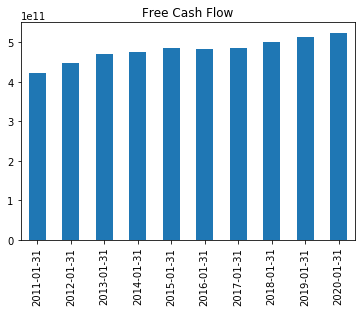

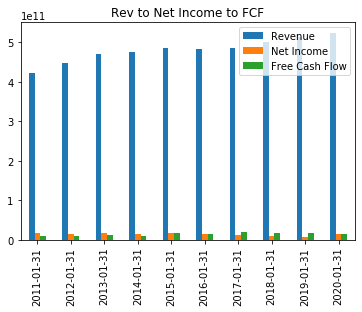

In [817]:
dcf_calculator(company,api_key,0.084)

In [ ]:
def get_wacc():
    